In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
pip install squarify

In [0]:
# import libraries
import datetime as dt
import pandas as pd
import numpy as np
#import librarys for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import squarify
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objects as go
import plotly.offline as pyoff
import plotly.express as px

#Exploratory Data Analysis

In [0]:
#loading data from csv
df = pd.read_csv(r'/content/drive/My Drive/ADM/Project/rfm/twitch_ds.csv')

In [5]:
df.head()

,Unnamed: 0,visit_id,start_time,viewer_id,duration,country,gender,age
0,0,536365,12/1/2018 8:26,17850.0,15.30,Russia,male,27
1,1,536365,12/1/2018 8:26,17850.0,20.34,Russia,male,27
2,2,536365,12/1/2018 8:26,17850.0,22.00,Russia,male,27
3,3,536365,12/1/2018 8:26,17850.0,20.34,Russia,male,27
4,4,536365,12/1/2018 8:26,17850.0,20.34,Russia,male,27


In [6]:
df.dtypes

Unnamed: 0      int64
visit_id        int64
start_time     object
viewer_id     float64
duration      float64
country        object
gender         object
age             int64
dtype: object

In [0]:
df=df.drop(['Unnamed: 0'], axis=1)

In [0]:
#taking only the dates and leaving out the timestamps
df['start_time'] = pd.to_datetime(df['start_time']).dt.date

In [9]:
df.dtypes

visit_id        int64
start_time     object
viewer_id     float64
duration      float64
country        object
gender         object
age             int64
dtype: object

In [10]:
#checking for number of unique users in the dataset
df.viewer_id.nunique()

4338

In [11]:
#checking for the distribution of users in various countries
df_countries = df['country'].value_counts()
print(df_countries)

United States         347640
Germany                22385
Russia                 12399
United Kingdom          4284
Brazil                  4098
Switzerland             1841
Portugal                1462
Italy                    758
Channel Islands          748
Finland                  685
Poland                   330
Japan                    321
Israel                   248
Singapore                222
Iceland                  182
Canada                   151
European Community        60
Lebanon                   45
Czech Republic            25
Name: country, dtype: int64


In [12]:
#Visualization of visitors in top 5 countries
source_counts = df['country'].value_counts()[:5].to_frame("Count").reset_index()

px.bar(
    source_counts, x="index", y="Count", template="plotly_white",
    labels=dict(Count="Number of Visits", index="Country"), 
    width=800, height=400, title="Visitors by country"
)

Since a majority of Twitch's userbase is in located in the US we have only considered users in this region

In [0]:
df_us = df.query("country=='United States'").reset_index(drop=True)

In [0]:
#create a generic user dataframe for keeping viewer_id's and new segmentation scores
df_user = pd.DataFrame(df['viewer_id'].unique())
df_user.columns = ['viewer_id']

In [15]:
df_user.head()

,viewer_id
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


#Recency

In [0]:
#get the most recent visit date (max visit) for each customer and create a dataframe with it
df_max_visit = df_us.groupby('viewer_id').start_time.max().reset_index()
df_max_visit.columns = ['viewer_id','MaxViewDate']

In [17]:
df_max_visit.head()

,viewer_id,MaxViewDate
0,12346.0,2019-01-18
1,12747.0,2019-12-07
2,12748.0,2019-12-09
3,12749.0,2019-12-06
4,12820.0,2019-12-06


In [0]:
#we take our observation point as the max visit date in our dataset
df_max_visit['Recency'] = (df_max_visit['MaxViewDate'].max() - df_max_visit['MaxViewDate']).dt.days

In [19]:
df_max_visit

,viewer_id,MaxViewDate,Recency
0,12346.0,2019-01-18,325
1,12747.0,2019-12-07,2
2,12748.0,2019-12-09,0
3,12749.0,2019-12-06,3
4,12820.0,2019-12-06,3
...,...,...,...
3869,18280.0,2019-03-07,277
3870,18281.0,2019-06-12,180
3871,18282.0,2019-12-02,7
3872,18283.0,2019-12-06,3


In [0]:
#merge this dataframe to our new user dataframe
df_user = pd.merge(df_user, df_max_visit[['viewer_id','Recency']], on='viewer_id')

In [21]:
df_user

,viewer_id,Recency
0,13047.0,31
1,13748.0,95
2,15100.0,333
3,15291.0,25
4,14688.0,7
...,...,...
3869,15471.0,2
3870,13436.0,1
3871,15520.0,1
3872,13298.0,1


In [22]:
#plotting a recency histogram
import plotly.express as px
fig = px.histogram(df_user, x="Recency")
fig.show()

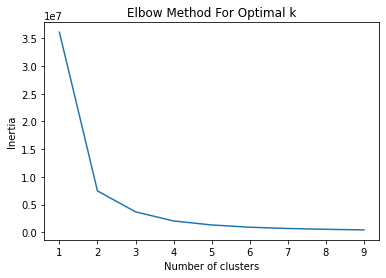

In [23]:
from sklearn.cluster import KMeans
sse={}
df_recency = df_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.ylabel("Inertia")
plt.xlabel("Number of clusters")
plt.title('Elbow Method For Optimal k')
plt.show()

In [0]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['Recency']])
df_user['RecencyCluster'] = kmeans.predict(df_user[['Recency']])

In [25]:
df_user.head()

,viewer_id,Recency,RecencyCluster
0,13047.0,31,2
1,13748.0,95,0
2,15100.0,333,1
3,15291.0,25,2
4,14688.0,7,2


In [26]:
df_user.describe()

,viewer_id,Recency,RecencyCluster
count,3874.000000,3874.000000,3874.000000
mean,15557.948116,90.001291,1.528653
std,1576.054435,96.539386,1.011848
min,12346.000000,0.000000,0.000000
25%,14201.750000,17.000000,1.000000
50%,15566.000000,50.000000,2.000000
75%,16909.750000,138.000000,2.000000
max,18287.000000,371.000000,3.000000


In [27]:
df_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,945.0,76.428571,20.669602,49.0,60.0,72.0,89.0,126.0
1,491.0,292.234216,40.001685,235.0,260.0,284.0,319.0,371.0
2,1883.0,18.497079,13.374455,0.0,7.0,17.0,29.0,47.0
3,555.0,176.798198,30.281036,127.0,151.5,176.0,201.0,234.0


In [0]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_user = order_cluster('RecencyCluster', 'Recency',df_user,False)

In [29]:
df_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,491.0,292.234216,40.001685,235.0,260.0,284.0,319.0,371.0
1,555.0,176.798198,30.281036,127.0,151.5,176.0,201.0,234.0
2,945.0,76.428571,20.669602,49.0,60.0,72.0,89.0,126.0
3,1883.0,18.497079,13.374455,0.0,7.0,17.0,29.0,47.0


 3 covers most recent customers whereas

#Frequency

In [0]:
#get order counts for each user and create a dataframe with it
df_frequency = df_us.groupby('viewer_id').start_time.count().reset_index()
df_frequency.columns = ['viewer_id','Frequency']

In [0]:
#add this data to our main dataframe
df_user = pd.merge(df_user, df_frequency, on='viewer_id')

In [32]:
#plotting a recency histogram
import plotly.express as px
fig = px.histogram(df_user, x=df_user.query('Frequency < 1000')['Frequency'])
fig.show()

In [0]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['Frequency']])
df_user['FrequencyCluster'] = kmeans.predict(df_user[['Frequency']])

In [0]:
#order the frequency cluster
df_user = order_cluster('FrequencyCluster', 'Frequency',df_user,True)

In [0]:
#see details of each cluster
df_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3429.0,48.594051,43.712814,1.0,15.0,33.0,72.0,185.0
1,419.0,322.720764,129.642777,186.0,221.5,282.0,384.0,756.0
2,23.0,1254.260870,476.314184,799.0,954.5,1106.0,1390.5,2660.0
3,3.0,5647.666667,1848.422661,4569.0,4580.5,4592.0,6187.0,7782.0


#Engagement

In [0]:
#calculate total engagement for each customer
df_us['Engagement'] = df_us['duration']
df_engagement = df_us.groupby('viewer_id').Engagement.sum().reset_index()

In [0]:
#merge it with our main dataframe
df_user = pd.merge(df_user, df_engagement, on='viewer_id')

In [0]:
#plotting a recency histogram
import plotly.express as px
fig = px.histogram(df_user, x=df_user.query('Engagement < 10000')['Engagement'])
fig.show()

In [0]:
#apply clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['Engagement']])
df_user['EngagementCluster'] = kmeans.predict(df_user[['Engagement']])

In [0]:
#order the cluster numbers
df_user = order_cluster('EngagementCluster', 'Engagement',df_user,True)

In [0]:
#show details of the dataframe
df_user.groupby('EngagementCluster')['Engagement'].describe()

,count,mean,std,min,25%,50%,75%,max
EngagementCluster,,,,,,,,
0,3672.0,999.569105,1048.375791,3.75,284.2625,601.825,1341.4650,5314.47
1,176.0,9574.363807,4866.050827,5344.92,6158.5350,7804.650,10897.9025,28882.44
2,23.0,51026.210435,15334.865065,31833.68,38523.5500,50491.810,59277.4400,89236.64
3,3.0,207560.196667,46963.820480,168472.50,181511.6450,194550.790,227104.0450,259657.30


#Overall Score

Overall Score is the addition of individual R, F, E Scores 


In [0]:
df_user['OverallScore'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['EngagementCluster']

In [0]:
df_user.groupby('OverallScore')['Recency', 'Frequency', 'Engagement'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Recency,Frequency,Engagement
OverallScore,,,
0,291.582150,22.858012,351.529148
1,176.339416,32.357664,563.324381
2,77.338870,45.949059,1006.218031
3,22.008136,68.767458,1188.518401
4,14.900000,276.519355,4025.053516
5,10.377193,406.903509,10666.000439
6,7.045455,872.863636,31903.746818
7,3.333333,1243.500000,118746.253333
8,1.666667,5647.666667,43351.156667


The scoring above clearly shows us that customers with score 8 is our best customers whereas 0 is the worst.

#Segmenting customers

To keep things simple, better we name these scores:
0 to 2: Low Value
3 to 4: Mid Value
5+: High Value
We can easily apply this naming on our dataframe:


In [0]:
df_user['Segment'] = 'Low-Value'
df_user.loc[df_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
df_user.loc[df_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [0]:
df_user

,viewer_id,Recency,RecencyCluster,Frequency,FrequencyCluster,Engagement,EngagementCluster,OverallScore,Segment
0,13047.0,31,3,155,0,2870.91,0,3,Mid-Value
1,15291.0,25,3,101,0,4339.50,0,3,Mid-Value
2,13705.0,7,3,18,0,393.72,0,3,Mid-Value
3,17924.0,11,3,29,0,2683.50,0,3,Mid-Value
4,13448.0,16,3,177,0,3095.41,0,3,Mid-Value
...,...,...,...,...,...,...,...,...,...
3869,17841.0,1,3,7782,3,40454.19,2,8,High-Value
3870,14096.0,4,3,4569,3,56739.25,2,8,High-Value
3871,16446.0,0,3,3,0,168472.50,3,6,High-Value
3872,17450.0,8,3,337,1,194550.79,3,7,High-Value


In [0]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = df_user.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Engagement': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

           Recency Frequency Engagement      
              mean      mean       mean count
Segment                                      
High-Value     9.4     620.6    19036.8   145
Low-Value    159.6      36.3      715.3  1944
Mid-Value     20.8     104.8     1681.1  1785


In [0]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','EngagementMean', 'Count']

In [0]:
rfm_level_agg

,RecencyMean,FrequencyMean,EngagementMean,Count
Segment,,,,
High-Value,9.4,620.6,19036.8,145
Low-Value,159.6,36.3,715.3,1944
Mid-Value,20.8,104.8,1681.1,1785


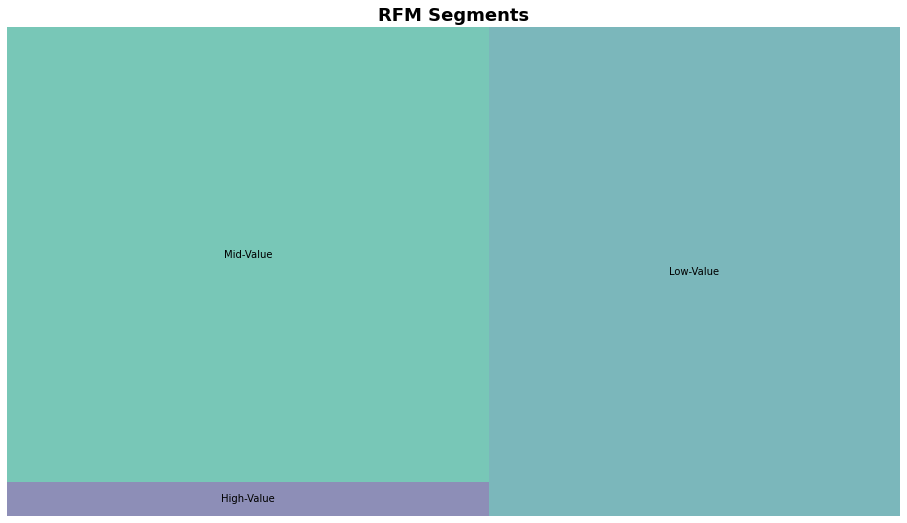

In [0]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['High-Value',
                     'Mid-Value', 
                     'Low-Value'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

In [0]:
#Engagement vs Frequency
df_graph = df_user.query("Engagement < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=df_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=df_graph.query("Segment == 'Low-Value'")['Engagement'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=df_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=df_graph.query("Segment == 'Mid-Value'")['Engagement'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=df_graph.query("Segment == 'High-Value'")['Frequency'],
        y=df_graph.query("Segment == 'High-Value'")['Engagement'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Engagement"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)#Engagement  Recency

df_graph = df_user.query("Engagement  < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=df_graph.query("Segment == 'Low-Value'")['Recency'],
        y=df_graph.query("Segment == 'Low-Value'")['Engagement'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=df_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=df_graph.query("Segment == 'Mid-Value'")['Engagement'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=df_graph.query("Segment == 'High-Value'")['Recency'],
        y=df_graph.query("Segment == 'High-Value'")['Engagement'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Engagement"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [0]:
# Engagement  vs Frequency
df_graph = df_user.query("Engagement < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=df_graph.query("Segment == 'Low-Value'")['Recency'],
        y=df_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=df_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=df_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=df_graph.query("Segment == 'High-Value'")['Recency'],
        y=df_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)